In [1]:
from dataloader_all import SP500DataLoader_
data_downloader_object = SP500DataLoader_()

    # Get cleaned return values
cleaned_returns = data_downloader_object.get_cleaned_returns(
        start_date=(2011, 1, 1), end_date=(2023, 1, 31),
        interval='1d', column='Adj Close', 
        save_as_h5=False, save_as_csv=True
    )

[**************        30%                       ]  152 of 504 completed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn
import csv
import datetime
from datetime import datetime

In [ ]:
df = pd.read_csv('Data/S&P500-cleaned_returns_all.csv')
with open('Data/S&P500-cleaned_returns_all.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter = ',')

  list_of_column_names = []
  for row in csv_reader:
    list_of_column_names.append(row)
    break

count = 0
dist = {}
for i in list_of_column_names[0]:
  if i == 'Date':
    continue
  dist[count] = i
  count += 1

In [ ]:
pos = 0
for i in df["Date"]:
  count = 0
  res = ''
  for j in i:
    res += j
    count += 1
    if count == 10:
      #print(res)
      res = datetime.strptime(res, '%Y-%m-%d').date()
      df.loc[pos,'Date'] = res
      break
  pos += 1

In [ ]:
DF = pd.DataFrame()
lcs = [i for i in df['Date']]
date_time = pd.to_datetime(lcs)
DF['value'] = df[dist[0]]
DF = DF.set_index(date_time)


In [ ]:
import torch
import time
import torch.nn as nn
import math
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from load_data import load_data
from LSTM import LSTM
from train import train_model

c:\Users\HungVo\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
scalar = StandardScaler()
df1 = scalar.fit_transform((np.array(DF['value'])).reshape(-1,1))
look_back = 32 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df1, look_back)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
model = LSTM(input_dim = 1, hidden_dim = 32, num_layers = 3, output_dim = 1)
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
hist = np.zeros(num_epochs)
train_model(num_epochs = num_epochs, model = model, loss_fn = loss_fn, optimiser = optimiser, x_train = x_train, y_train = y_train, hist = hist)


100%|██████████| 1500/1500 [22:08<00:00,  1.13it/s]


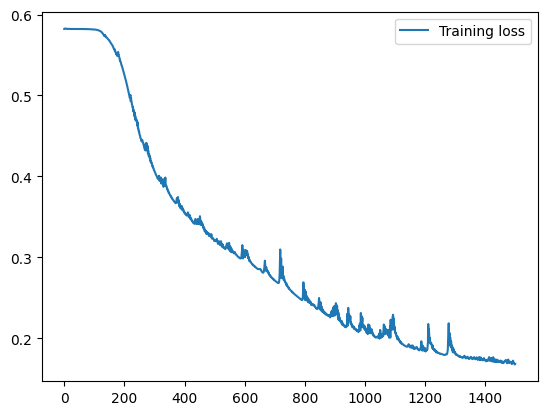

In [ ]:
plt.plot(hist, label="Training loss")
plt.savefig('Train.png')
plt.legend()
plt.show()

In [ ]:
model.eval()
with torch.inference_mode():
  y_test_pred = model(x_test)
  y_train_pred = model(x_train)
# invert predictions
y_train_pred = scalar.inverse_transform(y_train_pred.detach().numpy())
y_train = scalar.inverse_transform(y_train.detach().numpy())
y_test_pred = scalar.inverse_transform(y_test_pred.detach().numpy())
y_test = scalar.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

NameError: name 'model' is not defined

In [ ]:
y_train_pred 

NameError: name 'y_train_pred' is not defined

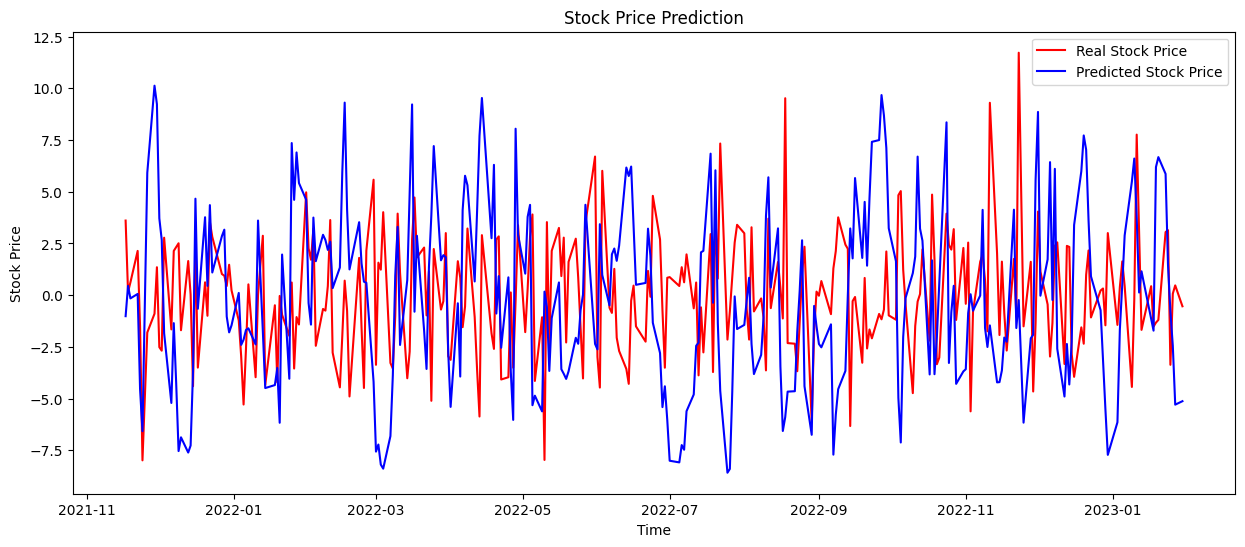

In [ ]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(DF[len(DF)-len(y_test):].index, y_test, color = 'red', label = 'Real Stock Price')
axes.plot(DF[len(DF)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('prediction.png')
plt.show()